In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np

import gym
import stable_baselines
from stable_baselines import A2C, ACER, ACKTR, DQN, DDPG, SAC, PPO1, PPO2, TD3, TRPO
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.gail import ExpertDataset
from stable_baselines.gail import generate_expert_traj

from fakegym.fakegym import FakeGym
import importlib

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
class MyObservation():
    def __init__(self, env):
        self.env = env
        self.gps_actual = None
        self.gps_target = None
        self.distance = None
        self.touching = None

    def _update(self):
        self.gps_actual = self.env.state_object.gps_actual
        self.gps_target = self.env.state_object.gps_target
        self.distance = self.env.state_object.distance
        self.touching = self.env.state_object.touching

    def shape(self):
        """Make sure length is correct here.In this example:
        gps_actual: 2
        gps_target: 2
        distance:   4
        touching:   1
        =================
                   (9, )
        
        """
        return (9, )

    def get(self, env):
        """Get observation as numpy array."""
        self._update()
        
        arr = np.empty(0)
        arr = np.hstack((arr, np.array(self.gps_actual)))
        arr = np.hstack((arr, np.array(self.gps_target)))
        arr = np.hstack((arr, np.array(self.distance)))
        arr = np.hstack((arr, np.array(self.touching)))
        
        return arr
    

class MyEnv(FakeGym):
    def __init__(self, seed=None, N=10, num_of_sensors=4, obstacles_each=2,
                 step_range=(1, 1), action_type="discrete",
                 discrete_action_shaping="flatten", obs=MyObservation):
        super(MyEnv, self).__init__(seed, N, num_of_sensors, obstacles_each, step_range, action_type, discrete_action_shaping, obs)
        

    def calc_reward(self):
        """Calculate reward function.

        Idea(Mats):
        - negative reward for normal move so that james moves faster to goal
        - still lower negative reward if james gets closer to goal
        - high positive award for reaching it
        - high negative award to hitting a wall
        - epsilon only to divide never by 0

        """
        if self.gps_actual == self.gps_target:
            reward = 1000
        else:
            epsilon = 10**-5
            cost_step = 1
            max_distance = np.sqrt(2)*self.com.N
            dist_penalty = self.get_target_distance()+epsilon
            #cost_distance = (distance**0.4)/(distance)
            cost_distance = np.tanh(dist_penalty/(max_distance/2))
            reward_factor = -1
            reward = reward_factor * (cost_step * cost_distance)
            if self.state_object:
                reward = reward - 10
        return reward
        
        
    def check_done(self):
        if self.com.time_steps == 1000:
            return True
        if self.gps_actual == self.gps_target:
            return True
        return False


env = MyEnv()
check_env(env)

In [3]:
#expert trajectory generate
time_steps = 10**4
reward_function = "nReward2"
fake = "WebotFakeMini"
name = "TRPO_pj1"
model_name = "PPO_{}_{}_{}_{}".format(fake, name, reward_function, time_steps)

model = PPO1("MlpPolicy", env, verbose=1)
n_epi = 1000
expert_name = "expert_ppo1_{}".format(n_epi)
generate_expert_traj(model, expert_name, n_timesteps=time_steps, n_episodes=n_epi)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
********** Iteration 0 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00078 |      -0.01386 |      8.99e+04 |       0.00069 |       1.38572
     -0.01572 |      -0.01382 |      8.97e+04 |       0.00401 |       1.38230
     -0.02195 |      -0.01376 |      8.96e+04 |       0.01017 |       1.37582
     -0.02608 |      -0.01371 |      8.95e+04 |       0.01484 |       1.37105
Evaluating losses...
     -0.02894 |      -0.01370 |      8.94e+04 |       0.01595 |       1.37001
----------------------------------
| EpLenMean       | 82.7         |
| EpRewMean       | 179          |
| EpThisIter      | 3            |
| EpisodesSoFar   | 3            |
| TimeElapsed     | 0.506        |
| Timesteps

Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
      0.00034 |      -0.01348 |      9.49e+04 |      8.73e-05 |       1.34752
     -0.00506 |      -0.01356 |      9.49e+04 |       0.00118 |       1.35601
     -0.01494 |      -0.01364 |      9.49e+04 |       0.00454 |       1.36445
     -0.01817 |      -0.01370 |      9.49e+04 |       0.01075 |       1.36983
Evaluating losses...
     -0.02012 |      -0.01371 |      9.49e+04 |       0.01413 |       1.37070
----------------------------------
| EpLenMean       | 187          |
| EpRewMean       | -869         |
| EpThisIter      | 3            |
| EpisodesSoFar   | 6            |
| TimeElapsed     | 1.61         |
| TimestepsSoFar  | 1280         |
| ev_tdlam_before | 0.000899     |
| loss_ent        | 1.3706956    |
| loss_kl         | 0.014134872  |
| loss_pol_entpen | -0.013706956 |
| loss_pol_surr   | -0.020118576 |
| loss_vf_loss    | 94906.55     |
----------------------------------
*******

********** Iteration 12 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
    -7.36e-06 |      -0.01348 |      9.04e+04 |      8.67e-06 |       1.34785
     -0.00158 |      -0.01347 |      9.04e+04 |      8.92e-05 |       1.34657
     -0.00604 |      -0.01346 |      9.03e+04 |       0.00040 |       1.34578
     -0.01066 |      -0.01345 |      9.03e+04 |       0.00179 |       1.34490
Evaluating losses...
     -0.01382 |      -0.01344 |      9.02e+04 |       0.00307 |       1.34402
----------------------------------
| EpLenMean       | 116          |
| EpRewMean       | -154         |
| EpThisIter      | 3            |
| EpisodesSoFar   | 28           |
| TimeElapsed     | 3.78         |
| TimestepsSoFar  | 3328         |
| ev_tdlam_before | -0.000593    |
| loss_ent        | 1.3440164    |
| loss_kl         | 0.0030700709 |
| loss_pol_entpen | -0.013440164 |
| loss_pol_surr   | -0.013818245 |
| loss_vf_loss    | 90239.51     |
-----

********** Iteration 20 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00046 |      -0.01287 |      1.85e+05 |      7.60e-05 |       1.28733
     -0.00534 |      -0.01287 |      1.85e+05 |       0.00128 |       1.28671
     -0.00754 |      -0.01283 |      1.85e+05 |       0.00333 |       1.28256
     -0.01111 |      -0.01276 |      1.84e+05 |       0.00342 |       1.27631
Evaluating losses...
     -0.01277 |      -0.01274 |      1.84e+05 |       0.00283 |       1.27378
----------------------------------
| EpLenMean       | 114          |
| EpRewMean       | -157         |
| EpThisIter      | 7            |
| EpisodesSoFar   | 47           |
| TimeElapsed     | 5.88         |
| TimestepsSoFar  | 5376         |
| ev_tdlam_before | 0.000434     |
| loss_ent        | 1.2737793    |
| loss_kl         | 0.0028296448 |
| loss_pol_entpen | -0.012737792 |
| loss_pol_surr   | -0.012771934 |
| loss_vf_loss    | 184292.53    |
-----

********** Iteration 28 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00041 |      -0.01302 |      1.88e+05 |      1.10e-05 |       1.30184
     -0.00318 |      -0.01300 |      1.87e+05 |       0.00017 |       1.29953
     -0.00691 |      -0.01296 |      1.87e+05 |       0.00074 |       1.29598
     -0.00757 |      -0.01293 |      1.87e+05 |       0.00129 |       1.29317
Evaluating losses...
     -0.00898 |      -0.01293 |      1.87e+05 |       0.00131 |       1.29261
----------------------------------
| EpLenMean       | 87.1         |
| EpRewMean       | 124          |
| EpThisIter      | 8            |
| EpisodesSoFar   | 85           |
| TimeElapsed     | 8            |
| TimestepsSoFar  | 7424         |
| ev_tdlam_before | 0.00131      |
| loss_ent        | 1.292608     |
| loss_kl         | 0.001314763  |
| loss_pol_entpen | -0.012926081 |
| loss_pol_surr   | -0.008980788 |
| loss_vf_loss    | 187050.25    |
-----

********** Iteration 36 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     3.74e-05 |      -0.01304 |      4.75e+04 |      3.30e-06 |       1.30397
     -0.00061 |      -0.01305 |      4.74e+04 |      2.45e-05 |       1.30452
     -0.00100 |      -0.01305 |      4.74e+04 |      7.65e-05 |       1.30489
     -0.00150 |      -0.01305 |      4.74e+04 |       0.00011 |       1.30477
Evaluating losses...
     -0.00175 |      -0.01304 |      4.74e+04 |       0.00010 |       1.30439
------------------------------------
| EpLenMean       | 99.6           |
| EpRewMean       | -11.2          |
| EpThisIter      | 1              |
| EpisodesSoFar   | 93             |
| TimeElapsed     | 10.2           |
| TimestepsSoFar  | 9472           |
| ev_tdlam_before | 0.000972       |
| loss_ent        | 1.3043935      |
| loss_kl         | 0.000100685036 |
| loss_pol_entpen | -0.0130439345  |
| loss_pol_surr   | -0.0017509665  |
| loss_vf_loss  

{'actions': array([[1],
        [1],
        [3],
        ...,
        [2],
        [2],
        [3]]),
 'obs': array([[4., 2., 3., ..., 1., 2., 0.],
        [5., 2., 3., ..., 1., 3., 0.],
        [5., 2., 3., ..., 1., 3., 1.],
        ...,
        [8., 1., 7., ..., 0., 7., 1.],
        [8., 1., 7., ..., 0., 7., 1.],
        [8., 1., 7., ..., 0., 7., 1.]]),
 'rewards': array([ -10.02827814,  -10.02827814,  -10.02235837, ...,  -10.01000108,
         -10.01000108, 1000.        ]),
 'episode_returns': array([ 8.39722157e+02,  6.98702342e+02,  8.99771815e+02,  6.48588350e+02,
         6.99255850e+02, -1.34415159e+02,  5.78732470e+02,  8.99725928e+02,
         7.59523942e+02, -6.59874594e+03,  8.89728077e+02,  9.49907742e+02,
         1.00000000e+03,  8.79667329e+02,  4.78739421e+02,  7.19266082e+02,
         9.49935855e+02,  9.69947642e+02,  6.19231925e+02, -1.64434964e+02,
         7.66744038e+01,  2.87318414e+02,  9.69969997e+02, -1.00652062e+04,
         8.49753996e+02,  4.68478897e+02,

In [4]:
test_N = 1000

In [5]:
#pretrained model
dataset = ExpertDataset(expert_path="{}.npz".format(expert_name), traj_limitation=1, batch_size=128)
model_pretrain = PPO1("MlpPolicy", env, verbose=1)
model_pretrain.pretrain(dataset, n_epochs=10**4)
step_pretrain = np.zeros(test_N)

for i in range(test_N):
    env = MyEnv(seed = i, N=10)
    obs = env.reset()
    done = False
    for _ in range(200):
        action, _states = model_pretrain.predict(obs)
        obs, rewards, done, info = env.step(action)
        #env.render()
        if done is True:
            step_pretrain[i] = _+1
            break

actions (100375, 1)
obs (100375, 9)
rewards (100375,)
episode_returns (1000,)
episode_starts (100375,)
Total trajectories: 1
Total transitions: 46
Average returns: -196.3011433997405
Std for returns: 2827.7202816579656


Pretraining with Behavior Cloning...
==== Training progress 10.00% ====
Epoch 1000
Training loss: 0.544249, Validation loss: 2.061663

==== Training progress 20.00% ====
Epoch 2000
Training loss: 0.312552, Validation loss: 2.971324

==== Training progress 30.00% ====
Epoch 3000
Training loss: 0.285719, Validation loss: 3.471897

==== Training progress 40.00% ====
Epoch 4000
Training loss: 0.279978, Validation loss: 3.818510

==== Training progress 50.00% ====
Epoch 5000
Training loss: 0.278027, Validation loss: 4.076188

==== Training progress 60.00% ====
Epoch 6000
Training loss: 0.277189, Validation loss: 4.298595

==== Training progress 70.00% ====
Epoch 7000
Training loss: 0.276784, Validation loss: 4.507297

==== Training progress 80.00% ====
Epoch 8000
Training l

In [6]:
#model never trained
model_new = PPO1("MlpPolicy", env, verbose=1)
step_2 = np.zeros(test_N)

for i in range(test_N):
    env = MyEnv(seed = i, N=10)
    obs = env.reset()
    done = False
    for _ in range(200):
        action, _states = model_new.predict(obs)
        obs, rewards, done, info = env.step(action)
        #env.render()
        if done is True:
            step_2[i] = _+1
            break

Text(0, 0.5, 'time')

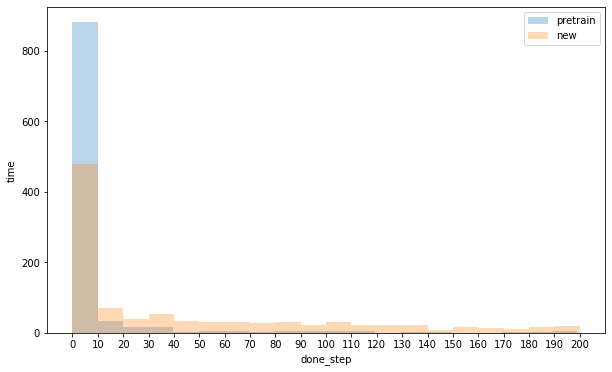

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(step_pretrain, bins=20, alpha=0.3, label = "pretrain")
plt.hist(step_2, bins=20, alpha=0.3, label = "new")
plt.legend()
my_x_ticks = np.arange(0, 210, 10)
plt.xticks(my_x_ticks)
plt.xlabel("done_step")
plt.ylabel("time")